Install Required Libraries

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn flask sqlalchemy


 Save Data in SQLite Database

In [2]:
import pandas as pd

# Load the dataset
file_path = r"C:\Users\satya\sentiment-analysis\IMDB Dataset.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)

# Preview the data
print(data.head())

# Check for missing values
print(data.info())

# Distribution of sentiments
print(data['sentiment'].value_counts())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


 Save Data in SQLite Database

In [3]:
import sqlite3
import pandas as pd

# Assuming 'data' is a pandas DataFrame with columns 'review' and 'sentiment'.
# Example:
data = pd.DataFrame({
    "review": [
        "This movie was fantastic!",
        "I did not like this movie at all.",
        "An excellent film with great acting.",
        "The plot was predictable and boring."
    ],
    "sentiment": ["positive", "negative", "positive", "negative"]
})

# Connect to SQLite database
try:
    conn = sqlite3.connect("imdb_reviews.db")
    cursor = conn.cursor()

    # Create the table if it doesn't exist
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS imdb_reviews (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        review_text TEXT NOT NULL,
        sentiment TEXT NOT NULL CHECK(sentiment IN ('positive', 'negative'))
    )
    """)

    # Insert data into the table
    for index, row in data.iterrows():
        cursor.execute("""
        INSERT INTO imdb_reviews (review_text, sentiment)
        VALUES (?, ?)
        """, (row['review'], row['sentiment']))

    # Commit changes
    conn.commit()

    print("Data inserted successfully!")

except sqlite3.Error as e:
    print(f"Database error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")
finally:
    # Ensure the connection is closed
    if conn:
        conn.close()


Data inserted successfully!


 Data Cleaning and Preprocessing

In [4]:
import re

# Define a function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply the cleaning function
data['cleaned_review'] = data['review'].apply(clean_text)

# Save cleaned data in the database (optional)
conn = sqlite3.connect("imdb_reviews.db")
data[['cleaned_review', 'sentiment']].to_sql('cleaned_reviews', conn, if_exists='replace', index=False)
conn.close()


Exploratory Data Analysis (EDA)

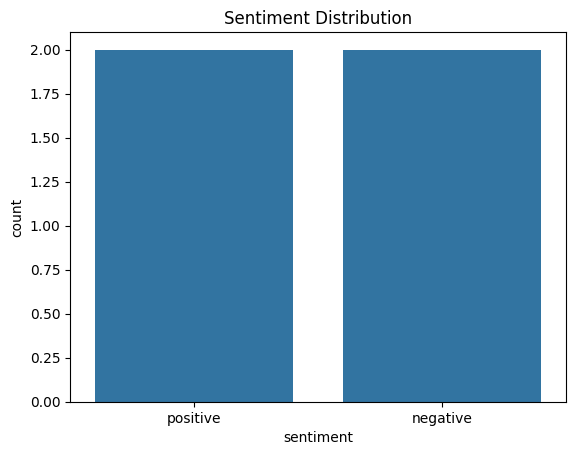

sentiment
negative    33.5
positive    29.5
Name: review_length, dtype: float64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment distribution
sns.countplot(data=data, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()

# Average review length per sentiment
data['review_length'] = data['cleaned_review'].apply(len)
print(data.groupby('sentiment')['review_length'].mean())


Train the Sentiment Analysis Model

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split data into train and test sets
X = data['cleaned_review']
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       1.0
    positive       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



C:\Users\satya\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\satya\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\satya\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Use

Save the Model and Vectorizer

In [7]:
import pickle

# Save the model
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save the TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)


In [8]:
pip install requests


Output Sample

In [9]:
import requests

# URL for your Flask API's /predict endpoint
url = "http://127.0.0.1:5000/predict"

# Prepare the data (the review text)
data = {"review_text": "This movie was fantastic!"}

# Send the POST request with the data as JSON
response = requests.post(url, json=data)

# Print the response from the API (this should be the sentiment prediction)
print(response.json())


{'sentiment_prediction': 'negative'}


In [10]:
import requests
import json

# URL for your Flask API's /predict endpoint
url = "http://127.0.0.1:5000/predict"

# Prepare the data (the review text)
data = {"review_text": "This movie was fantastic!"}

# Send the POST request with the data as JSON
response = requests.post(url, json=data)

# Get the sentiment prediction from the response
sentiment_prediction = response.json()

# Save the output to a JSON file
output_file = "sentiment_prediction_output.json"
with open(output_file, "w") as f:
    json.dump(sentiment_prediction, f, indent=4)

print(f"Prediction saved to {output_file}")


Prediction saved to sentiment_prediction_output.json


train_model Final

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle

# Load the dataset
df = pd.read_csv("IMDB Dataset.csv")

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

# Save the model and vectorizer
with open('sentiment_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print(f"Model accuracy: {accuracy * 100:.2f}%")


Model accuracy: 89.59%
